# Categorical perception

In [1]:
# # generalimport pymc
import os
import sys
import glob
import datetime

# EXTERNAL DEPENDENCIES
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from multiprocessing import Pool

# sound processing
# import wavio
# import soundsig
import soundfile as sf
from soundsig.sound import BioSound, spec_colormap, WavFile
from scipy.io import wavfile

# Statistics
from scipy.stats import norm, chi2, zscore
from pymer4.models import Lmer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# import scipy.stats
# from sklearn.metrics import accuracy_score
# from soundsig.sound import spectrogram, plot_spectrogram

# Plotting
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#  Modules from this repository
sys.path.append(os.path.join(os.getcwd(), "..", "code"))
from load_data import load_stimulus, load_all_data, extract_new

# The diretory for saving figures - Change to place of your choice
figDir = os.path.expanduser('~/Desktop/')

In [2]:
call_type_colors = { 'TE':(140/255.0, 100/255.0, 185/255.0),
                    'DC': '#9bcd7b',
                    'TH':(255/255.0, 150/255.0, 40/255.0),}

- 1. Import Data
    - A.Import behavior data
    - B.Read Wav Files of Sound Stimuli, Generate Spectrograms and Save to h5 Files.
    - C.Read h5 files
    
- 2. LDA on the stimuli

- 3. Correlates Accoustic to Behavior
    - A. Plot raw data (sup. fig.A)
    - B. Extract stimuli distribution (sup. fig.B)
    - C. Fit and plot models (main fig.A)
    - D. Compare tasks
    - E. Tasks on the same scale (main fig.B)
    - F. Model comparison plots (main fig.C)

# 1.Import Data

## A. Import behavior data

In [3]:
all_df = load_all_data()

all_df = all_df[all_df['bird'] != 'WhiHpi7966F']
learning_df = all_df[all_df['day'] == 'control']
shaping_df = all_df[all_df['day'] == 'learning']
naive_df = all_df[all_df['day'] == 'naif']

all_df['bird'].unique()

array(['HpiXXX7700M', 'BluGre3435F', 'GreGre1819F', 'HpiGre2990M',
       'GreBlu4813M', 'RedYel0836M', 'LblGre1214F'], dtype=object)

In [4]:
#### separate old / new stimluli for the congruant day

new_learning_df_DC, old_learning_df_DC = extract_new(learning_df[learning_df['test'] == 'DCvsTET'], 'DCvsTET')
new_learning_df_TH, old_learning_df_TH = extract_new(learning_df[learning_df['test'] == 'THvsTET'], 'THvsTET')

old_learning_df = pd.concat([old_learning_df_DC, old_learning_df_TH])
new_learning_df = pd.concat([new_learning_df_DC, new_learning_df_TH])


## B. Import Sound Data and make spectrograms

#### You can skip B and go to C.  The raw wave files are not included in the git repository
 

In [ ]:
# You can skip these steps as the Table with spectrograms is saved as data

path = '/auto/zdrive/aude/stimuli/box2'
directory = os.listdir(path)
filenames = []

path_dir = '/auto/zdrive/aude/stimuli/box2/confusing_stim/'
filespath = (glob.glob(path_dir + "*.wav"))


stimuli_to_analyze = list(old_learning_df.stimulus_name.unique())
stimuli_to_analyze = [os.path.split(f)[-1] for f in stimuli_to_analyze]

calls = []
birds = []
renditions = []
files  = []
    
for f in filespath :
    name = os.path.split(f)[-1]
    
    if name in stimuli_to_analyze :
        files.append(f)
        filenames.append(name)
        carac = name.split('_')
        calls.append(carac[0])
        renditions.append(carac[2])
        birds.append(carac[3])

In [6]:
h5_outpath = '/auto/zdrive/aude/Code/zebra-finch-semantic-category/data/acoustic_confusion'

In [ ]:
normalize = False

def procSound(n):

    soundIn = WavFile(file_name = files[n]) 
    soundIn.data = soundIn.data[:int(.5*soundIn.sample_rate)]
    birdname = birds[n]
    calltype = calls[n]
    rendition = renditions[n]

    # Normalize if wanted
    if normalize :
        maxAmp = np.abs(soundIn.data).max() 
    else :
        maxAmp = 1.0

    # Create BioSound Object and store some values
    myBioSound = BioSound(soundWave=soundIn.data.astype(float)/maxAmp, fs=float(soundIn.sample_rate), emitter=birdname, calltype = calltype)

    # Calculate the spectrogram and the rms
    myBioSound.spectroCalc(spec_sample_rate=1000, freq_spacing = 50, min_freq=0, max_freq=10000)
#     myBioSound.rms = myBioSound.sound.std() 

#     # Calculate amplitude enveloppe
#     myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 1000)

#     # Calculate the power spectrum
#     myBioSound.spectrum(f_high=10000)

    # Calculate fundamental and related values
#     myBioSound.fundest()

#     # Calculate the MPS
#     myBioSound.mpsCalc(window=0.1, Norm = True)

    myBioSound.source_fn = np.string_(files[n])
    # Save the results
    fname = '%s/%s_%s_%s_%d.h5' % (h5_outpath,bytes(myBioSound.emitter).decode('utf-8'), bytes(myBioSound.type).decode('utf-8'),rendition, n)
    myBioSound.saveh5(fname)
    return fname

pool = Pool(8)
spects = list(tqdm(pool.imap(procSound, range(len(files))), total=len(files)))                   
pool.close()


In [92]:
list_ct = [s.split('/')[-1].split('_')[1] for s in spects]
dico_spects = {}
for ct in set(list_ct) :
    dico_spects[ct] = np.array(spects)[np.where(np.array(list_ct) == ct)[0].tolist()]

In [ ]:
wav_folder = '/auto/zdrive/aude/stimuli/box2/confusing_stim/'
h5_files = glob.glob("%s/*"%h5_outpath)
store = '/auto/zdrive/aude/Code/zebra-finch-semantic-category/data/acoustic_confusion/ConfusingCallTable'

def proc_h5(fname):
    bsound = BioSound()
    bsound.readh5(fname)
    

#     if bsound.fund.shape != (0,):
    soundSpect = np.copy(bsound.spectro)
    spectrogram_500ms = soundSpect[:, :350]
    
    is_neginf = np.isneginf(spectrogram_500ms)
    full_column_is_neginf = is_neginf.all(axis=0)
    try:
        first_full_neginf_column = np.where(full_column_is_neginf)[0][0]
        spectrogram_500ms[:, first_full_neginf_column:] = 0
#         print(f"The first column where all values are -inf is at index: {first_full_neginf_column}")
    except IndexError:
        print("No column has all values as -inf.")
    
    spectrogram_flat = spectrogram_500ms.flatten()
#     else:
#         soundSpect = None 

    bname = bytes(bsound.emitter).decode('utf-8')
    ct = bytes(bsound.type).decode('utf-8')
    fn = bytes(bsound.source_fn).decode('utf-8')
    rendition = fn.split('/')[-1].split('_')[2]
    
    if not os.path.exists("%s"%(fn)):
        sr = 0
        print("Missing %s"%(fn))
    else:
        f = sf.SoundFile("%s"%(fn))
        sr = f.samplerate
    return {"Bird": bname,
            "calltype": ct,
            "rendition": rendition,
            "spectro": spectrogram_500ms, 
            "spectro_flat": spectrogram_flat,
            "filename": fn, 
            "samplerate":sr}


for ct in dico_spects.keys():
    pool = Pool(8)
    vocSelData = list(tqdm(pool.imap(proc_h5, dico_spects[ct]), total=len(dico_spects[ct])))                   
    vocSelTable = pd.DataFrame(vocSelData)
    vocSelTable.to_hdf(store+ct, 'callTable', mode = 'w', complib='blosc')
    pool.close()

## C. Read the data tables that have the spectrograms

In [5]:
vocSelTableDC = pd.read_hdf('../data/acoustic_confusion/ConfusingCallTableDC')
vocSelTableTe = pd.read_hdf('../data/acoustic_confusion/ConfusingCallTableTe')
vocSelTableTh = pd.read_hdf('../data/acoustic_confusion/ConfusingCallTableTh')
vocSelTable = pd.concat([vocSelTableDC, vocSelTableTe, vocSelTableTh], ignore_index = True)

In [6]:
# Add the task the stimuli were used in
# NEW_list_stim_names_DC = ['_'.join([x.split('/')[-1].split('_')[3], x.split('/')[-1].split('_')[0],  x.split('/')[-1].split('_')[2]]) for x in new_learning_df_DC.stimulus_name.unique()]
# NEW_list_stim_names_Th = ['_'.join([x.split('/')[-1].split('_')[3], x.split('/')[-1].split('_')[0],  x.split('/')[-1].split('_')[2]]) for x in new_learning_df_TH.stimulus_name.unique()]
OLD_list_stim_names_DC = ['_'.join([x.split('/')[-1].split('_')[3], x.split('/')[-1].split('_')[0],  x.split('/')[-1].split('_')[2]]) for x in old_learning_df_DC.stimulus_name.unique()]
OLD_list_stim_names_Th = ['_'.join([x.split('/')[-1].split('_')[3], x.split('/')[-1].split('_')[0],  x.split('/')[-1].split('_')[2]]) for x in old_learning_df_TH.stimulus_name.unique()]


TEvsDC = [False]*len(vocSelTable)
TEvsTH = [False]*len(vocSelTable)

for i, row in vocSelTable.iterrows():
    stim_name = '_'.join([row.Bird, row.calltype, row.rendition])
    if stim_name in OLD_list_stim_names_DC :
        TEvsDC[i] = 'old'
    if stim_name in OLD_list_stim_names_Th :
        TEvsTH[i] = 'old'

vocSelTable['TEvsDC'] = TEvsDC
vocSelTable['TEvsTH'] = TEvsTH
vocSelTable['calltype_upper'] = vocSelTable['calltype'].str.upper()

vocTEvsDC = vocSelTable[vocSelTable['TEvsDC'] != False]
vocTEvsTH = vocSelTable[vocSelTable['TEvsTH'] != False]


## 2. LDA on the Spectrograms

In [7]:
def getXlda(voctabletask,calc_mode = 'normalized', plot_coef=False):
    # Extract features and labels for the stim the bird has been trained on (old stimuli)
    X = np.vstack(voctabletask.spectro_flat.values)
    X[np.isinf(X)] = np.nan  # Convert inf to NaN to handle them together
    X = np.nan_to_num(X, nan=0)
    y = voctabletask.calltype_upper.values

    # Create and fit LDA for the stim the bird has been trained on (old stimuli)
    lda = LinearDiscriminantAnalysis()
    
    X_lda = {}
    X_lda['automatic'] = lda.fit_transform(X, y)
    X_lda['manual'] = np.dot(X, lda.coef_.T) + lda.intercept_
    normValue = np.sqrt(np.sum(lda.coef_*lda.coef_))
    X_lda['normalized'] = np.dot(X, lda.coef_.T/normValue) + lda.intercept_/normValue 
    voctabletask['Xlda'] = X_lda[calc_mode]
    
    if plot_coef :
        spectro_coefs_TEvsDC = lda_TEvsDC.coef_.T.reshape(196, 350)
        # Plot as a spectrogram
        plt.figure(figsize=(5, 3))
        plt.imshow(spectro_coefs_TEvsDC, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='Intensity') 
        plt.title('Spectrogram of Coefs')
        plt.ylabel('f')
        plt.xlabel('time')
        plt.show()
    
    return voctabletask

In [8]:
vocTEvsDC = getXlda(vocTEvsDC)    
vocTEvsTH = getXlda(vocTEvsTH) 
vocTEvsTH['Xlda'] = -1*vocTEvsTH['Xlda']

/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_24512/2226011919.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voctabletask['Xlda'] = X_lda[calc_mode]
/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_24512/2226011919.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voctabletask['Xlda'] = X_lda[calc_mode]
/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_24512/1948601454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


# 3. Correlates Accoustic to Behavior (sup fig)

### a. Extract and plot behavior

In [9]:
def create_behavior_df(new_learning_df, voc):
    interruptions_row = []
    for (bird, vocalizer, calltype, stimname), sub_behavior_df in new_learning_df.groupby(['bird', 'Stimulus Vocalizer', 'Stimulus Call Type', 'stimulus_name']):

        rendition = stimname.split('/')[-1].split('_')[2]
        if calltype == 'TE' :
            behavior = sub_behavior_df.correct.astype(int).tolist()
        elif calltype != 'TE' :
            behavior = [1-b for b in sub_behavior_df.correct.astype(int).tolist()]

        stim_Xlda = voc[
            (voc['Bird'] == vocalizer) & 
            (voc['calltype_upper'] == calltype) & 
            (voc['rendition'] == rendition)]['Xlda'].values[0]
        
        interruptions_row.append([bird, vocalizer, calltype, rendition, stim_Xlda, behavior])
    interruptions_df = pd.DataFrame(interruptions_row, columns = ['bird', 'vocalizer', 'calltype', 'rendition', 'stim_Xlda', 'behavior'])
    return interruptions_df

In [10]:
new_shaping_df = shaping_df.copy()
for (bird, calltype), bird_ct_df in shaping_df.groupby(['bird', 'Stimulus Call Type']):
    old_vocalizer = naive_df[
        (naive_df['bird'] == bird) & (naive_df['Stimulus Call Type'] == calltype)
    ]['Stimulus Vocalizer'].unique()[0]
    old_vocalizer_indexes = bird_ct_df[bird_ct_df['Stimulus Vocalizer'] == old_vocalizer].index
    # Ensure indices exist in the DataFrame before dropping
    valid_indexes = new_shaping_df.index.intersection(old_vocalizer_indexes)
    new_shaping_df = new_shaping_df.drop(valid_indexes, axis=0)
new_shaping_df[new_shaping_df.bird==bird]['Stimulus Vocalizer'].unique()


new_shaping_TEvsTHdf = create_behavior_df(new_shaping_df[new_shaping_df.test == 'THvsTET'], vocTEvsTH)
new_shaping_TEvsDCdf = create_behavior_df(new_shaping_df[new_shaping_df.test == 'DCvsTET'], vocTEvsDC)

In [13]:
def plot_all_birds_performance(df):
    # Extract behavior trial by trial
    df = df.explode('behavior')
    df['behavior'] = df['behavior'].astype(int)

    # Calculate the mean interruption rate per stimulus (grouped by vocalizer, calltype, rendition)
    df['stimulus'] = df['vocalizer'] + '_' + df['calltype'] + '_' + df['rendition'].astype(str)
    mean_interruption_rate = df.groupby(['stimulus', 'vocalizer', 'calltype', 'rendition', 'stim_Xlda', 'bird'])['behavior'].mean().reset_index(name='mean_rate')

    # Plot mean interruption rate as a function of Xlda
    unique_birds = mean_interruption_rate['bird'].unique()
    num_birds = len(unique_birds)
    cols = 2  # Number of columns in the grid
    rows = (num_birds // cols) + (num_birds % cols)  # Calculate the number of rows needed

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 2 * rows), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten to easily iterate over all axes

    colors = plt.cm.get_cmap('viridis', len(mean_interruption_rate['calltype'].unique()))

    for idx, (ax, bird) in enumerate(zip(axes, unique_birds)):
        bird_data = mean_interruption_rate[mean_interruption_rate['bird'] == bird]
        call_types = bird_data['calltype'].unique()
        for i, call_type in enumerate(call_types):
            color = call_type_colors.get(call_type, 'black')
            mask = bird_data['calltype'] == call_type
            ax.scatter(bird_data[mask]['stim_Xlda'], bird_data[mask]['mean_rate'], label=call_type, color=color, alpha=0.7)
        ax.set_title(f'{bird}')
#         ax.set_ylabel('Probability of classification as Tet')
#         ax.legend()
#         ax.grid(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Hide any empty subplots if the number of birds is less than the number of grid cells
    for idx in range(len(unique_birds), len(axes)):
        fig.delaxes(axes[idx])

    plt.xlabel('X LDA')
#     plt.suptitle('Probability of classification as Tet per Stimulus as a Function of X LDA, per Bird', y=1.02)
    plt.savefig(figDir+ f'Raw_data_{call_types}.svg')
    plt.tight_layout()
    plt.show()


/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_24512/2667406722.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(mean_interruption_rate['calltype'].unique()))


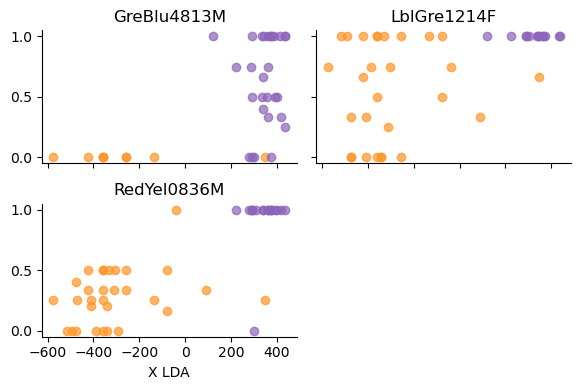

/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_24512/2667406722.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(mean_interruption_rate['calltype'].unique()))


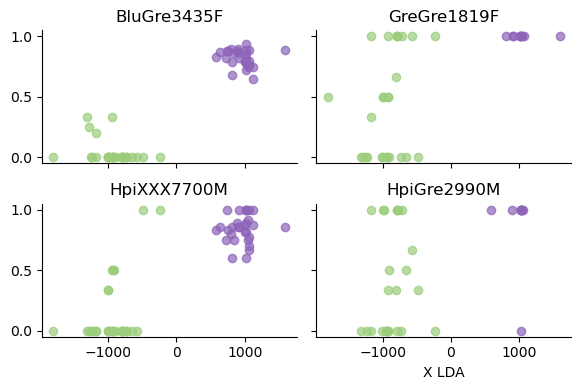

In [14]:
plot_all_birds_performance(new_shaping_TEvsTHdf)
plot_all_birds_performance(new_shaping_TEvsDCdf)

## B. Extract stimuli distribution (sup. fig)

#### Plotting the optimal categorization curve (red plain curve)

p(categorized as Tet) = 1/(1+exp(-gS+b))

- g is the gain of the logisitc function. g = (mu_te - mu_other) / (sigma_c^2 + sigma_s^2)
- b is the bias b of the logisitc function. b = (mu_te^2 - mu_other^2) / (2 * (sigma_c^2 + sigma_s^2)) = 2

We assume gaussian distrubution of Te and the other call along Xlda. From this distributions we calculated mu_te, mu_other, and sigma_c = (sigma_Te + sigma_other) / 2.

In [15]:
def manual_log_likelihood(y, p_values):
    log_likelihood = 0
    for i, p_i in enumerate(p_values):
        # Ensure probabilities are clipped to avoid log(0) issues
        p_i = np.clip(p_i, 1e-10, 1 - 1e-10)

        # Calculate observed number of successes and total trials
        k_i = sum(y[i])  # Number of '1' responses
        n_i = len(y[i])  # Total number of responses

        # Calculate the log-likelihood contribution for this stimulus
        log_likelihood += k_i * np.log(p_i) + (n_i - k_i) * np.log(1 - p_i)

    return log_likelihood

# Define the logistic function
def logistic_function(x, g, b):
    return 1 / (1 + np.exp(-g * x + b))


def plot_optimal_categorization(df_exploded, mu_sigmaC_values_task, call_types, otherct, S, y, ax_main):
    # Extract parameters for TEvsTH
    mu_te = mu_sigmaC_values_task['mu']['TE']
    mu_other = mu_sigmaC_values_task['mu'][otherct]
    sigma_c = mu_sigmaC_values_task['sigmaC']
    sigma_s = 0  # Set sigma_s to 0

    # Calculate parameters g and b
    g = (mu_te - mu_other) / (sigma_c**2 + sigma_s**2)
    b = (mu_te**2 - mu_other**2) / (2 * (sigma_c**2 + sigma_s**2))
    
    # Generate x values for the logistic curve
    x_values = np.linspace(df_exploded['stim_Xlda'].min(), df_exploded['stim_Xlda'].max(), 500)

    # Calculate y values for plotting using the logistic function
    y_values_plot = logistic_function(x_values, g, b)

    # Calculate p values (predicted probabilities) for all given stimulus values S
    p_values = [logistic_function(S_i, g, b) for S_i in S]
    
    # Calculate log-likelihood using the precomputed p_values
    log_likelihood = manual_log_likelihood(y, p_values)
        
    print(f'Log-Likelihood optimal fit: {log_likelihood}')

    # Plot the logistic function fit
    ax_main.plot(x_values, y_values_plot, color='red', linestyle='-', linewidth=1, label='Logistic Function Fit')
    
    return (log_likelihood, 3)


Log-Likelihood optimal fit: -4053.470120399469
Log-Likelihood optimal fit: -1282.9248848113928


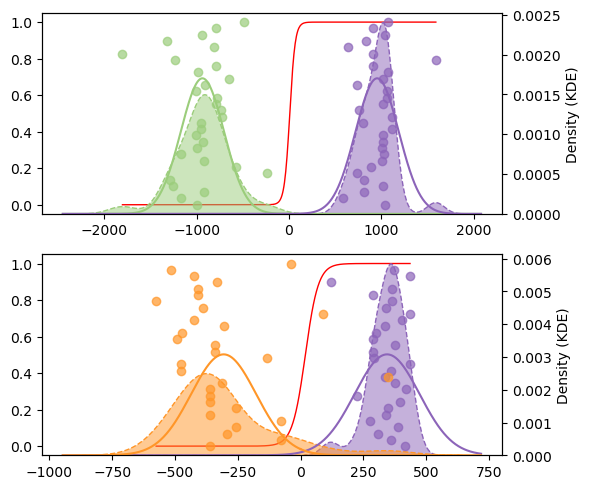

{'TEvsDC': {'mu': {'DC': -938.2711178285734, 'TE': 954.6547811310973}, 'sigmaC': 234.42347080776156}, 'TEvsTH': {'mu': {'TE': 344.8220133035778, 'TH': -306.2376995042228}, 'sigmaC': 129.55363207136116}}


In [16]:
def plot_lda_with_kde_shaping(taskdf, shaping_data, shaping_labels, unique_labels,task,otherct, title, ax1, new_stim = True):
    
    # Create a secondary y-axis for KDE plots
    ax2 = ax1.twinx()
    
    # Extract means and standard deviations, then plot Gaussians
    mu_sigmaC = extract_and_plot_gaussian_shaping(shaping_data, shaping_labels, unique_labels, ax2)
    S = np.array(taskdf.stim_Xlda.values)
    y_values = (list(taskdf.behavior.values))
    plot_optimal_categorization(taskdf, mu_sigmaC, unique_labels, otherct, S, y_values, ax1)
    
    # KDE plots on the second axis (ax2) with shaded areas
    for label in unique_labels:
        color = call_type_colors.get(label, 'black')  # Default to black if label not in the dictionary
        sns.kdeplot(x=shaping_data[shaping_labels == label], 
                        color=color, linestyle='--', ax=ax2, label=label + ' kde', alpha=0.5, fill=True)

    ax2.set_ylabel('Density (KDE)')

    # Combine legends from both axes (for better visualization)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
#     ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

    ax3 = ax1.twinx()
    
    for label in unique_labels:
        color = call_type_colors.get(label, 'black')  # Default to black if label not in the dictionary
        
        # Scatter plot for new data
        mask_new = shaping_labels == label
        ax3.scatter(shaping_data[mask_new], np.arange(len(shaping_data[mask_new])),  
                    marker='o', label=label + ' new', color=color, alpha=0.7)
    ax3.set_axis_off()
    
    mu_sigmaC = extract_and_plot_gaussian_shaping(shaping_data, shaping_labels, unique_labels, ax2)

#     ax1.grid(True)
    
    return mu_sigmaC

def extract_and_plot_gaussian_shaping(shaping_data, shaping_labels, unique_labels, ax, new_stim = True):
    mu_values = []
    sigma_values = []

    # Calculate mu and sigma for each call type
    for label in unique_labels:
#         combined_data = np.concatenate([old_data[old_labels == label, 0], new_data[new_labels == label, 0]])
        combined_data = shaping_data[shaping_labels == label]
        mu = np.mean(combined_data)
        sigma = np.std(combined_data)
        mu_values.append((label, mu))
        sigma_values.append(sigma)
        
    sigmaC = np.mean(sigma_values)
    
    # Plot Gaussian curves for each call type
    x_range = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
    for label, mu in mu_values:
        color = call_type_colors.get(label, 'black')  # Default to black if label not in the dictionary
        y_gaussian = norm.pdf(x_range, mu, sigmaC)
        ax.plot(x_range, y_gaussian, color=color, linestyle='-', label=f'{label} Gaussian (mu={mu:.2f}, sigmaC={sigmaC:.2f})', alpha=1)
    
    # Return mu and sigmaC values
    return {'mu': dict(mu_values), 'sigmaC': sigmaC}

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 1, figsize=(6, 5))

# Store mu and sigmaC values
shaping_mu_sigmaC_values = {}

# Plot 1: TEvsDC

shaping_Xlda_TEvsDC = np.squeeze(list(new_shaping_TEvsDCdf.groupby(['vocalizer','calltype','rendition']).stim_Xlda.unique()))
shaping_labels_TEvsDC = np.squeeze(list(new_shaping_TEvsDCdf.groupby(['vocalizer','calltype','rendition']).calltype.unique()))

shaping_mu_sigmaC_values['TEvsDC'] = plot_lda_with_kde_shaping(
    taskdf= new_shaping_TEvsDCdf,
    shaping_data=shaping_Xlda_TEvsDC,
    shaping_labels=shaping_labels_TEvsDC,
    unique_labels=vocTEvsDC.calltype_upper.unique(),
    task = 'TEvsDC',
    otherct = 'DC',
    title='',
    ax1=axes[0]
)

# Plot 2: TEvsTH
shaping_Xlda_TEvsTH = np.squeeze(list(new_shaping_TEvsTHdf.groupby(['vocalizer','calltype','rendition']).stim_Xlda.unique()))
shaping_labels_TEvsTH = np.squeeze(list(new_shaping_TEvsTHdf.groupby(['vocalizer','calltype','rendition']).calltype.unique()))


shaping_mu_sigmaC_values['TEvsTH'] = plot_lda_with_kde_shaping(
    taskdf = new_shaping_TEvsTHdf,
    shaping_data=shaping_Xlda_TEvsTH,
    shaping_labels=shaping_labels_TEvsTH,
    unique_labels=vocTEvsTH.calltype_upper.unique(),
    task = 'TEvsTH',
    otherct = 'TH',
    title='',
    ax1=axes[1]
)

plt.savefig(figDir + 'gauss_stimuli.svg')

plt.tight_layout()
plt.show()

print(shaping_mu_sigmaC_values)

## C. Fit and plot models (main fig.A)

In [17]:
def plot_rawdata_simplified(df_exploded, call_types, otherct, ax_main):
    # Colors for filling areas representing behaviors
    color_te_fill = call_type_colors.get('TE', 'black')
    color_other_fill = call_type_colors.get(otherct, 'black')

    # Define the rolling window size for calculating the sliding mean
    window_size = 20 

    # Loop over each call type to plot the proportion of behavior = 1 for each stimulus
    for call_type in call_types:
        # Filter data for the current call type
        call_type_df = df_exploded[df_exploded['calltype'] == call_type]

        # Calculate proportion of behavior = 1 for each bird at each unique stim_Xlda value
        bird_summary = (
            call_type_df.groupby(['bird', 'stim_Xlda'])
            .agg(total_count=('behavior', 'size'),
                 count_1=('behavior', lambda x: (x == 1).sum()))
            .reset_index()
        )
        bird_summary['proportion_1'] = bird_summary['count_1'] / bird_summary['total_count']

        # Calculate the mean proportion across birds for each stim_Xlda
        mean_proportions = (
            bird_summary.groupby('stim_Xlda')['proportion_1']
            .mean()
            .reset_index()
            .sort_values(by='stim_Xlda')
        )

        # Extract values for plotting
        bird_x_values = bird_summary['stim_Xlda']
        bird_y_values = bird_summary['proportion_1']

        # Scatter plot for each bird's proportion of behavior = 1 for each stimulus
        color = call_type_colors.get(call_type, 'black')
#         ax_main.scatter(bird_x_values, bird_y_values, color=color, alpha=0.9, label=f'{call_type} individual bird data')

        # Plot the rolling mean of bird-level mean proportions
        x_mean_values = mean_proportions['stim_Xlda']
        y_mean_values = mean_proportions['proportion_1']

        # Apply rolling mean to smooth the mean of bird means
        y_rolling_mean = y_mean_values.rolling(window=window_size, min_periods=1, center=True).mean()

        # Plot the rolling mean as a line
        ax_main.plot(x_mean_values, y_rolling_mean, color=color, linewidth=1, label=f'{call_type} rolling mean across birds')

        # Fill areas above and below the rolling mean line
        ax_main.fill_between(x_mean_values, y_rolling_mean, 1, where=(y_rolling_mean < 1),
                             color=color_other_fill, alpha=0.1, interpolate=True)
        ax_main.fill_between(x_mean_values, 0, y_rolling_mean, where=(y_rolling_mean > 0),
                             color=color_te_fill, alpha=0.3, interpolate=True)

#### Fitting a GLM (dotted curves)

Y∼stim_Xlda+(1∣bird)

In [18]:
def plot_glm(df_exploded, formula, color, ax_main, ax_legend, info_y):
    # Fit the GLMM with binomial family
    glmm = Lmer(formula, data=df_exploded, family='binomial')
    glmm.fit()

    # Print the summary of the model
    print(glmm.summary())

    # Get predictions from the GLMM model for plotting purposes
    x_glm = np.linspace(df_exploded['stim_Xlda'].min(), df_exploded['stim_Xlda'].max(), 500)
    predict_df = pd.DataFrame({'stim_Xlda': x_glm, 'bird': df_exploded['bird'].cat.categories[0]})
    glmm_predictions = glmm.predict(predict_df, verify_predictions=False)

    # Plot the GLMM prediction
    ax_main.plot(x_glm, glmm_predictions, color=color, linestyle='--', linewidth=1, label='GLMM Prediction (Pymer4)')

    # Extract the coefficient and p-value for stim_Xlda
    stim_Xlda_effect = glmm.fixef.get('stim_Xlda', None)
    stim_Xlda_pvalue = glmm.coefs.loc['stim_Xlda', 'P-val'] if 'stim_Xlda' in glmm.coefs.index else None
    # Check if stim_Xlda_effect and stim_Xlda_pvalue are valid (not None)
    if stim_Xlda_effect is not None and stim_Xlda_pvalue is not None:
        # Convert to floats if they are scalars, otherwise extract the scalar value
        if isinstance(stim_Xlda_effect, pd.Series):
            stim_Xlda_effect = stim_Xlda_effect.iloc[0]
        if isinstance(stim_Xlda_pvalue, pd.Series):
            stim_Xlda_pvalue = stim_Xlda_pvalue.iloc[0]
    # Display the information in the legend subplot
#     ax_legend.text(0, 0.9 - 0.1*info_y,
#                 f"Xlda effect: {stim_Xlda_effect:.2f}, p-value: {stim_Xlda_pvalue:.4f}, logLike: {glmm.logLike:.2f}", color=color, fontsize=10)
    
    return (glmm.logLike, glmm.coefs.shape[0])

In [86]:
def categorization_plot_simplified(taskdf, task,mu_sigmaC_values, spectro_coefs = None, selected_spectro = None):
    # Define the main figure and subplots
#     fig, (ax_main, ax_legend) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 1]})
#     fig.t  ight_layout(pad=5.0)
     

    AIC_models = {}
    LR_models = {}
    
    fig = plt.figure(figsize=(7,4))
    ax_main = plt.gca()
    
    # Data
    df_exploded = taskdf.copy()
    df_exploded = df_exploded.explode('behavior', ignore_index=True)
    df_exploded['behavior'] = pd.to_numeric(df_exploded['behavior'])

    # Get call types
    call_types = df_exploded['calltype'].unique()
    otherct = list(call_types)
    otherct.remove('TE')
    otherct = otherct[0]

    # RAW DATA #
    plot_rawdata_simplified(df_exploded, call_types,otherct, ax_main)

    
    # GLMs #
    # Make bird a category
    df_exploded['bird'] = df_exploded['bird'].astype('category')
    nbirds = df_exploded['bird'].cat.categories.shape[0]

    # See if rescaling makes a difference
    # df_exploded['stim_Xlda'] = zscore(df_exploded['stim_Xlda'])
    # The warning goes away

    # First GLM with stim only
    formula = 'behavior ~ stim_Xlda + (1|bird)'
    glmm = Lmer(formula, data=df_exploded, family='binomial')
    glmm.fit(REML=False)
    # Get predictions from the GLMM model for plotting purposes
    x_glm = np.linspace(df_exploded['stim_Xlda'].min(), df_exploded['stim_Xlda'].max(), 500)
    glmm_predictions = np.zeros(x_glm.shape)

    for ibird in range(nbirds):
        predict_df = pd.DataFrame({'stim_Xlda': x_glm, 'bird': df_exploded['bird'].cat.categories[ibird]})
        glmm_predictions += glmm.predict(predict_df, verify_predictions=False)
    glmm_predictions /= nbirds


    # Plot the GLMM prediction
    ax_main.plot(x_glm, glmm_predictions, color='black', linestyle='-', linewidth=1, label='LMERP Sound')

    logLike, degfree = glmm.logLike, glmm.coefs.shape[0]
    AIC_models['acoustic'] = glmm.AIC
    LR_models['acoustic'] = logLike

    # GLM WITH CALL TYPE #
    formula = 'behavior ~ stim_Xlda + calltype + (1|bird)'
    glmm_ct = Lmer(formula, data=df_exploded, family='binomial')
    glmm_ct.fit(REML=False)
    print(glmm_ct.summary())
   
    # Ploting 
    x_range = np.linspace(df_exploded['stim_Xlda'].min(), df_exploded['stim_Xlda'].max(), 100)
    for call_type in call_types:

        predictBirds = np.zeros(x_range.shape)
        for ib in range(nbirds):
            predict_df = pd.DataFrame({
                'stim_Xlda': x_range,
                'calltype': [call_type] * len(x_range),
                'bird': [df_exploded['bird'].cat.categories[ib]] * len(x_range)  # Use an arbitrary bird, random effects are marginalized out
            })
    
            predictBirds  += glmm_ct.predict(predict_df, verify_predictions=False, skip_data_checks=True)
        predictBirds /= nbirds

        color = call_type_colors.get(call_type, 'black')
        ax_main.plot(x_range, predictBirds, color=color,linestyle='--', linewidth=1, label=f'LMERP Sound+Call {call_type}')

        # Get the fit parameters from the model
        callTypeGLM = glmm_ct.coefs.index[2]   # To make it general this is the name for the non-intercept call-type variable
        callGLM = callTypeGLM[-2:]  # This is the 2 carachter call-type

        # The model coefficients
        b0 = glmm_ct.coefs.Estimate['(Intercept)']
        bstim = glmm_ct.coefs.Estimate['stim_Xlda']
        bcall =  glmm_ct.coefs.Estimate[callTypeGLM]

        # The model prediction
        if call_type == callGLM:
            etaX = b0 + bcall + bstim*x_range
        else:
            etaX = b0 + bstim*x_range
        predictAll = 1/(1+np.exp(-etaX))
        # ax_main.plot(x_range, predictAll, color=color,linestyle=':', linewidth=1, label=f'LMERM Sound+Call {call_type}')
    
    # Log likelyhoods #
    df_exploded['predicted_prob'] = glmm_ct.predict(df_exploded,verify_predictions=False, skip_data_checks=True)
#     p = df_exploded['predicted_prob'].values
#     y = df_exploded['behavior'].values
#     y_list = [[response] for response in y]
#     manual_logLike = manual_log_likelihood(y_list, p)
    logLike_ct = glmm_ct.logLike
    LR_models['acoustic + calltype'] = logLike_ct
    AIC_models['acoustic + calltype'] = glmm_ct.AIC
#     print(f'Log-Likelihood Difference (Manual vs. GLMM): {manual_logLike} vs. {logLike_ct}')
    degfree_ct = glmm_ct.coefs.shape[0]
    print('CT + ACOUSTIC VS ACOUSTIC')
    print(f'degree of freedom for model with call type {glmm_ct.coefs.shape[0]}, {glmm_ct.coefs.shape}')
    likelihood_ratio_stat = -2 * (logLike - logLike_ct)
    df_diff =degfree_ct - degfree
    p_value = chi2.sf(likelihood_ratio_stat, df_diff)
    print(f"Likelihood Ratio Statistic: {likelihood_ratio_stat}")
    print(f"Degrees of Freedom: {df_diff}")
    print(f"P-value: {p_value}")
#     ax_legend.text(0, 0.9 - 0.1*info_y,
#                 f"Hyp : Acoustic + Call Type > Acoustic \n Likelihood Ratio Statistic: {likelihood_ratio_stat}, Degrees of Freedom: {df_diff},\n P-value: {p_value}", color='black', fontsize=10)

    # GLM WITH ONLY CALL TYPE #
    formula = 'behavior ~ calltype + (1|bird)'
    glmm_onlyCT = Lmer(formula, data=df_exploded, family='binomial')
    glmm_onlyCT.fit(REML=False)
    print(glmm_onlyCT.summary())
    
    # Ploting #
    x_range = np.linspace(df_exploded['stim_Xlda'].min(), df_exploded['stim_Xlda'].max(), 100)
    for call_type in df_exploded['calltype'].unique():
        predictBirds = np.zeros(x_range.shape)
        for ib in range(nbirds):
            predict_df = pd.DataFrame({
                'stim_Xlda': x_range,
                'calltype': [call_type] * len(x_range),
                'bird': [df_exploded['bird'].cat.categories[ib]] * len(x_range)  # Use an arbitrary bird, random effects are marginalized out
            })
    
            predictBirds  += glmm_onlyCT.predict(predict_df, verify_predictions=False, skip_data_checks=True)
        predictBirds /= nbirds

        color = call_type_colors.get(call_type, 'black')
        ax_main.plot(x_range, predictBirds, color=color,linestyle='dotted', linewidth=2, label=f'LMER Call {call_type}')
    
    # likelyhood test #
    logLike_onlyct = glmm_onlyCT.logLike
    AIC_models['calltype'] = glmm_onlyCT.AIC
    LR_models['calltype'] = logLike_onlyct
    degfree_onlyct = glmm_onlyCT.coefs.shape[0]
    print('CT + ACOUSTIC VS CT')
    likelihood_ratio_stat = -2 * (logLike_onlyct - logLike_ct)
    df_diff =degfree_ct - degfree_onlyct
    p_value = chi2.sf(likelihood_ratio_stat, df_diff)
    print(f"Likelihood Ratio Statistic: {likelihood_ratio_stat}")
    print(f"Degrees of Freedom: {df_diff}")
    print(f"P-value: {p_value}")
    
#     ax_legend.text(0, 0.9 - 0.1*info_y,
#                 f"Hyp : Acoustic + Call Type > Call Type \n Likelihood Ratio Statistic: {likelihood_ratio_stat}, Degrees of Freedom: {df_diff},\n P-value: {p_value}", color='black', fontsize=10)

    
    ax_main.set_xlim(df_exploded['stim_Xlda'].min() + df_exploded['stim_Xlda'].min()/5,
                     df_exploded['stim_Xlda'].max() + df_exploded['stim_Xlda'].max()/5)
    # Plot spectrograms along Xlda axis
    if selected_spectro is not None :
        plot_spectrograms_along_xlda(fig, ax_main, False, vocTEvsDC, 
                                     call_type_colors,  selected_spectro, 
                                     spectro_coefs = spectro_coefs,
                                     spectro_size = [1,1],
                                    title = True,
                                    y_offset = -0.4)

    # CUSTOM PLOT #
    # Main plot for the binned data and GLMM
    
    ax_main.set_xlabel('LDA1')
    ax_main.set_ylabel(f'Proportion Classified as {otherct}')
#     ax_main.set_title('GLMM Predictions for Call Types')
    ax_main.set_ylim(-0.05, 1.05)
    ax_main.set_xlim(df_exploded['stim_Xlda'].min(), df_exploded['stim_Xlda'].max())
    ax_main.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax_main.set_yticklabels(['1', '0.75', '0.5', '0.25', '0'])
    ax_twinx = ax_main.twinx()
    ax_twinx.set_ylim(-0.05, 1.05)
    ax_twinx.tick_params(labelright = True)
    ax_twinx.set_ylabel(f'Proportion Classified as Te')
    ax_twinx.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax_twinx.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])
    ax_main.grid(False)
    ax_twinx.tick_params(top=False,left=False, labeltop=False, labelright=True)

    ax_twinx.set_xlim(df_exploded['stim_Xlda'].min() + df_exploded['stim_Xlda'].min()/5,
                     df_exploded['stim_Xlda'].max() + df_exploded['stim_Xlda'].max()/5)
    
    ax_twinx.spines['top'].set_visible(False)
    ax_twinx.spines['left'].set_visible(False)
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['left'].set_color(call_type_colors.get(otherct, 'black'))
    ax_main.spines['left'].set_linewidth(3)
    ax_main.spines['right'].set_visible(False)
    ax_twinx.spines['right'].set_color(call_type_colors.get('TE', 'black'))
    ax_twinx.spines['right'].set_linewidth(3)

    


    # CUSTOM LEGENDS 
#     te_circle = mlines.Line2D([], [], color=call_type_colors.get('TE', 'black'), marker='o', linestyle='None', markersize=10, alpha=0.6, label='Proportion of TE classified as TE')
#     other_circle = mlines.Line2D([], [], color=call_type_colors.get(otherct, 'black'), marker='o', linestyle='None', markersize=10, alpha=0.6, label=f'Proportion of {otherct} classified as TE')
    te_legend = mlines.Line2D([], [], color=call_type_colors.get('TE', 'black'), marker='s', linewidth=2, alpha=0.6, label='Proportion classified as TE')
    other_legend = mlines.Line2D([], [], color=call_type_colors.get(otherct, 'black'), marker='s', linewidth=2, alpha=0.6, label=f'Proportion classified as {otherct}')
    
#     optimal_legend = mlines.Line2D([], [], color='red', linestyle='-', linewidth=2, label='Optimal Categorization according to Griffiths et al.')
#     glmm_te_legend = mlines.Line2D([], [], color=call_type_colors.get('TE', 'black'), linestyle='--', linewidth=2, label='GLMM Prediction TE')
#     glmm_other_legend = mlines.Line2D([], [], color=call_type_colors.get(otherct, 'black'), linestyle='--', linewidth=2, label=f'GLMM Prediction {otherct}')
#     glmm_legend = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label='GLMM Prediction')
    model2_te_legend = mlines.Line2D([], [], color=call_type_colors.get('TE', 'black'), linestyle='--', linewidth=2, label='GLMM (Acoustic + Call Type) Prediction TE')
    model2_other_legend = mlines.Line2D([], [], color=call_type_colors.get(otherct, 'black'), linestyle='--', linewidth=2, label=f'GLMM (Acoustic + Call Type) Prediction {otherct}')
    model3_te_legend = mlines.Line2D([], [], color=call_type_colors.get('TE', 'black'), linestyle='dotted', linewidth=2, label='GLMM (Call Type) Prediction TE')
    model3_other_legend = mlines.Line2D([], [], color=call_type_colors.get(otherct, 'black'), linestyle='dotted', linewidth=2, label=f'GLMM (Call Type) Prediction {otherct}')
    model1_legend = mlines.Line2D([], [], color='black', linestyle='-', linewidth=2, label='GLMM (Acoustic) Prediction')

#     # Create a legend plot in the second subplot
#     ax_legend.axis('off')
#     ax_legend.legend(handles=[
# #         te_circle, other_circle,
#         te_legend,other_legend,  
# #         optimal_legend, 
#         model2_te_legend, model2_other_legend, model3_te_legend, model3_other_legend, model1_legend], title='Legend', loc='center')
    plt.draw()
    plt.savefig(figDir + f'{task}.svg')
    plt.show()
    
    return AIC_models,LR_models

In [97]:
def plot_spectro(ax_spectro,wave_path, title, color, xlim, ylim, fig_size = (2,4)) :
    samplingFrequency, signalData = wavfile.read(wave_path)

    myBioSound = BioSound(soundWave=signalData, fs=samplingFrequency, emitter='STRF', calltype = 'song')
    myBioSound.spectroCalc(spec_sample_rate=1000, freq_spacing = 50, min_freq=0, max_freq=10000)
    
    ax_spectro.set_xticks([])
    ax_spectro.set_yticks([])

    # Color map for spectrograms
    spec_colormap()   # defined in sound.py
    cmap = plt.get_cmap('SpectroColorMap')
    DBNOISE = 50  # Color Threshold for spectrogram


    # The spectrogram
    soundSpect = np.copy(myBioSound.spectro)
    maxB = soundSpect.max()
    minB = maxB-DBNOISE
    soundSpect[soundSpect < minB] = minB
    minSpect = soundSpect.min()
    ax_spectro.imshow(soundSpect, extent=[myBioSound.to[0], myBioSound.to[-1], myBioSound.fo[0]*1e-3, myBioSound.fo[-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
    ax_spectro.set_ylim(ylim)
    ax_spectro.set_xlim(xlim)
    ax_spectro.set_ylabel('Frequency (kHz)')
    ax_spectro.set_title(title, fontsize=12, color = color,fontweight='bold')
    
    ax_spectro.set_xlabel('Time (s)')

    ax_spectro.spines["top"].set_visible(False)
    ax_spectro.spines["bottom"].set_visible(False)
    ax_spectro.spines["right"].set_visible(False)
    ax_spectro.spines["left"].set_visible(False)

def plot_spectro_from_array(ax_spectro,array_spectro, title, color, xlim, ylim, fig_size = (2,4)) :
    
    ax_spectro.set_xticks([])
    ax_spectro.set_yticks([])

    # Color map for spectrograms
    spec_colormap()   # defined in sound.py
    cmap = plt.get_cmap('SpectroColorMap')
    DBNOISE = 50  # Color Threshold for spectrogram


    # The spectrogram
    maxB = array_spectro.max()
    minB = maxB-DBNOISE
    array_spectro[array_spectro < minB] = minB
    minSpect = array_spectro.min()
    time_extent = np.linspace(0, array_spectro.shape[1]-1, array_spectro.shape[1])/1000   # Time is in s and sampling rate in ms.
    freq_extent = np.linspace(0, 10000, array_spectro.shape[0]) # From biosound spectrograms up to 10hHz
    ax_spectro.imshow(array_spectro, extent=[time_extent[0], time_extent[-1], freq_extent[0]*1e-3, freq_extent[-1]*1e-3],
                      aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
    ax_spectro.set_ylim(ylim)
    ax_spectro.set_xlim(xlim)
    ax_spectro.set_ylabel('Frequency (kHz)')
    ax_spectro.set_title(title, fontsize=12, color = color,fontweight='bold')
    
    ax_spectro.set_xlabel('Time (s)')

    ax_spectro.spines["top"].set_visible(False)
    ax_spectro.spines["bottom"].set_visible(False)
    ax_spectro.spines["right"].set_visible(False)
    ax_spectro.spines["left"].set_visible(False)
    

In [98]:
def plot_spectrograms_along_xlda(fig, ax_main, ax_legend, df, call_type_colors, selected_spectro,spectro_coefs=[],spectro_size = [1.5,1.5], title = True,y_offset = -0.8):
    # Settings for spectrogram placement
    spectro_width = spectro_size[0]  # Width of spectrogram in inches 
    spectro_height = spectro_size[1]  # Height of spectrogram in inches 
    y_offset = y_offset 

    # Iterate over each selected spectrogram row to place it along the x-axis
    for _, row in selected_spectro.iterrows():
        xlda_value = row['Xlda']
        filename = row['filename']
        color = call_type_colors.get(row['calltype'].upper(), 'black')

        # Use `inset_axes` to add spectrogram axes at the correct data position along the x-axis
        ax_spectro = inset_axes(
            ax_main,
            width=spectro_width,  # Width in inches
            height=spectro_height,  # Height in inches
            loc='center',  # Centered at the anchor point
            bbox_to_anchor=(xlda_value, y_offset),  # Use data coordinate for x position, fixed y offset
            bbox_transform=ax_main.transData,  # Use data coordinate system for x position
            borderpad=0,  
        )
        
        # Plot the spectrogram in the inset axis
        plot_spectro_from_array(ax_spectro, row['spectro'], f'Xlda = {round(row.Xlda, 2)}' if title else None, color,[0, 0.22], [0, 10], fig_size=(2, 4))
        # plot_spectro(ax_spectro, filename, f'Xlda = {round(row.Xlda, 2)}' if title else None, color,[0, 0.22], [0, 10], fig_size=(2, 4))
        ax_spectro.set_title(f'Xlda = {round(row.Xlda, 2)}' if title else None, color = color, fontsize = 8)
        ax_spectro.axis('off')  # Hide axis for better aesthetics
    if ax_legend:
        # Define the appropriate size for the spectrogram coefficients plot
        Xbbox = ax_legend.get_position()  # Get the bounding box of the legend
        Ybbox = ax_legend.get_position()
        # Use `inset_axes` to add spectrogram axes at the correct data position along the x-axis
        ax_spectro_coef = inset_axes(
                ax_legend,
                width=spectro_width,  # Width in inches
                height=spectro_height,  # Height in inches
                loc='center',  # Centered at the anchor point
                bbox_to_anchor=(Xbbox.x0, Ybbox.y0+y_offset/2),  # Use data coordinate for x position, fixed y offset
                bbox_transform=ax_legend.transData,  # Use data coordinate system for x position
                borderpad=0  # No padding between parent and inset axes
            )
    
#     ax_spectro_coef = fig.add_axes([bbox.x0 + 0.05 * bbox.width, bbox.y0 - 0.4, bbox.width * 0.9, 0.3])
#     plot_spectro_from_array(ax_spectro_coef, spectro_coefs, 'Spectro Coef', 'black', [0, 0.22], [0, 10], fig_size=(2, 4)) 

In [99]:
# SELECTION OF SPECTROGRAMS

OldvocTEvsTH = vocTEvsTH[vocTEvsTH.TEvsTH == 'old']

# OldvocTEvsTH[OldvocTEvsTH.Xlda>300] # index 337 PurRas20dd	Te	8, index 227 GraGra0201 TH 10
# OldvocTEvsTH[OldvocTEvsTH.Xlda>200][vocTEvsTH.Xlda<300] # index 271 WhiBlu4818	Te	3
# OldvocTEvsTH[OldvocTEvsTH.Xlda>0][vocTEvsTH.Xlda<200] # index 343 WhiBlu4818	Te	9
# OldvocTEvsTH[OldvocTEvsTH.Xlda>-100][vocTEvsTH.Xlda<100] # index 218 GreOra1817	TH	9
# OldvocTEvsTH[OldvocTEvsTH.Xlda>-400][vocTEvsTH.Xlda<-200] # index 217 GraGra0201	TH	9
# OldvocTEvsTH[OldvocTEvsTH.Xlda<-300] # index 190 GreOra1817	TH	7

choice_spect = [['PurRas20dd', 'TE', '8'], ['GraGra0201', 'TH', '10'], ['WhiBlu4818', 'TE', '3'], 
                ['WhiBlu4818', 'TE', '9'], ['GreOra1817', 'TH', '9'], ['GraGra0201', 'TH', '9'],
               ['GreOra1817', 'TH', '7']]
choice_idex = []
for vocalizer, calltype, rendition in choice_spect :
    choice_idex.append(OldvocTEvsTH[(OldvocTEvsTH['Bird'] == vocalizer) & 
                                    (OldvocTEvsTH['calltype_upper'] == calltype) & 
                                    (OldvocTEvsTH['rendition'] == rendition)].index.values[0])

selected_spectro_TEvsTH = OldvocTEvsTH[OldvocTEvsTH.index.isin(choice_idex)]
selected_spectro_TEvsTH

,Bird,calltype,rendition,spectro,spectro_flat,filename,samplerate,TEvsDC,TEvsTH,calltype_upper,Xlda
56,WhiBlu4818,Te,9,"[[-2.371548023956848, -2.371548023956848, -2.3...","[-6.084070107802711, -4.858926894943223, -3.38...",/auto/zdrive/aude/stimuli/box2/confusing_stim/...,44100,old,old,TE,6.710497
64,PurRas20dd,Te,8,"[[-1.5438372151807727, -1.5438372151807727, -1...","[-26.018545878688705, -27.42950483832386, -26....",/auto/zdrive/aude/stimuli/box2/confusing_stim/...,44100,False,old,TE,436.240424
92,WhiBlu4818,Te,3,"[[-5.409015267195727, -5.409015267195727, -5.4...","[-14.694448820113536, -12.41434023670486, -12....",/auto/zdrive/aude/stimuli/box2/confusing_stim/...,44100,old,old,TE,273.445111
119,GraGra0201,Th,9,"[[8.894246903363594, 8.894246903363594, 8.8942...","[-0.30236545069217935, 0.27420503099620086, 1....",/auto/zdrive/aude/stimuli/box2/confusing_stim/...,44100,False,old,TH,-304.416649
137,GraGra0201,Th,10,"[[7.2093114576089405, 7.2093114576089405, 7.20...","[-2.356159175864759, -1.0960909051018746, -0.8...",/auto/zdrive/aude/stimuli/box2/confusing_stim/...,44100,False,old,TH,347.126030
140,GreOra1817,Th,9,"[[6.606505519444575, 6.606505519444575, 6.6065...","[-4.845847359025021, -2.987116166668647, -2.62...",/auto/zdrive/aude/stimuli/box2/confusing_stim/...,44100,False,old,TH,-39.345640
145,GreOra1817,Th,7,"[[6.018332057808628, 6.018332057808628, 6.0183...","[3.749922617062788, 5.396619952613323, 5.80033...",/auto/zdrive/aude/stimuli/box2/confusing_stim/...,44100,False,old,TH,-422.611684


In [96]:
selected_spectro_TEvsTH['spectro'].iloc[5].shape

(196, 350)

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: behavior~stim_Xlda+(1|bird)

Family: binomial	 Inference: parametric

Number of observations: 285	 Groups: {'bird': 3.0}

Log-likelihood: -169.392 	 AIC: 344.783

Random effects:

             Name    Var    Std
bird  (Intercept)  0.862  0.928

No random effect correlations specified

Fixed effects:

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                   

/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: behavior~calltype+(1|bird)

Family: binomial	 Inference: parametric

Number of observations: 285	 Groups: {'bird': 3.0}

Log-likelihood: -157.625 	 AIC: 321.249

Random effects:

             Name    Var    Std
bird  (Intercept)  2.578  1.606

No random effect correlations specified

Fixed effects:

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: behavior~calltype+(1|bird)

Family: binomial	 Inference: parametric

Number of observations: 285	 Groups: {'bird': 3.0}

Log-likelihood: -157.625 	 AIC: 321.249

Random effects:

             Name    Var    Std
bird  (Intercept)  2.578  1.606

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     2.663   0.542    4.784  1.082  14.337      1.720     119.523   
calltypeTH     -3.972  -5.592   -2.352  0.826   0.019      0.004       0.095   

              Prob  Pro

/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


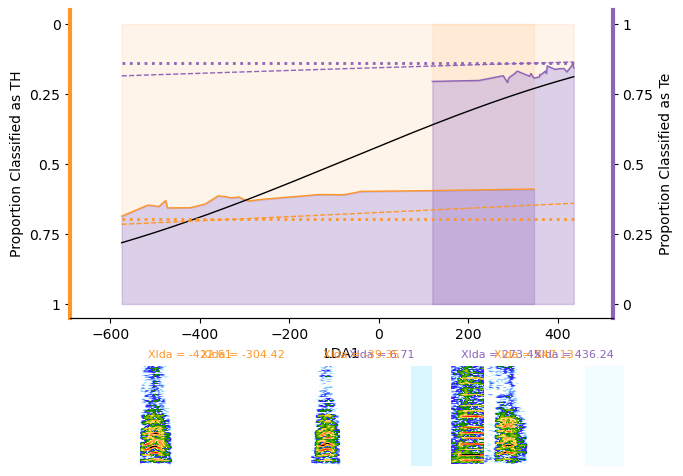

In [100]:
AIC_models_TEvsTH, LR_models_TEvsTH = categorization_plot_simplified(taskdf = new_shaping_TEvsTHdf, 
                                task = 'TEvsTH', 
                                mu_sigmaC_values=shaping_mu_sigmaC_values,
#                                 spectro_coefs = spectro_coefs_TEvsTH, 
                                selected_spectro= selected_spectro_TEvsTH,
                                )

In [ ]:
# SELECTION OF SPECTROGRAMS

OldvocTEvsDC = vocTEvsDC[vocTEvsDC.TEvsDC == 'old']
# OldvocTEvsDC[OldvocTEvsDC.Xlda<-1500] # index 55 YelGre5275	DC	4
# OldvocTEvsDC[OldvocTEvsDC.Xlda>-1500][OldvocTEvsDC.Xlda<-1000] # index 82 BlaLbl8026	DC	8
# OldvocTEvsDC[OldvocTEvsDC.Xlda>-1000][OldvocTEvsDC.Xlda<0] # index 15 YelGre5275	DC	1
# OldvocTEvsDC[OldvocTEvsDC.Xlda>0][OldvocTEvsDC.Xlda<700] # index 354 BlaLbl8026	TE	10
# OldvocTEvsDC[OldvocTEvsDC.Xlda>700][OldvocTEvsDC.Xlda<1000] # index 281 WhiBlu4818	TE	4
# OldvocTEvsDC[OldvocTEvsDC.Xlda>1000] # index 270 WhiBlu5698	TE	3

choice_spect = [['YelGre5275', 'DC', '4'], ['BlaLbl8026', 'DC', '8'], ['YelGre5275', 'DC', '1'], 
                ['BlaLbl8026', 'TE', '10'], ['WhiBlu4818', 'TE', '4'], ['WhiBlu5698', 'TE', '3'],]

choice_idex = []
for vocalizer, calltype, rendition in choice_spect :
    choice_idex.append(OldvocTEvsDC[(OldvocTEvsDC['Bird'] == vocalizer) & 
                                    (OldvocTEvsDC['calltype_upper'] == calltype) & 
                                    (OldvocTEvsDC['rendition'] == rendition)].index.values[0])

selected_spectro_TEvsDC = OldvocTEvsDC[OldvocTEvsDC.index.isin(choice_idex)]
selected_spectro_TEvsDC

In [ ]:
AIC_models_TEvsDC, LR_models_TEvsDC = categorization_plot_simplified(taskdf = new_shaping_TEvsDCdf, 
                        task = 'TEvsDC', 
                        mu_sigmaC_values=shaping_mu_sigmaC_values,
#                         spectro_coefs = spectro_coefs_TEvsDC, 
                        selected_spectro= selected_spectro_TEvsDC
                                                                    )

## D. Compare Tasks

In [ ]:
# Combine datasets
combined_data = pd.concat([new_shaping_TEvsTHdf.assign(Task='TEvsTH'), new_shaping_TEvsDCdf.assign(Task='TEvsDC')])
df_exploded = combined_data.copy()
df_exploded = df_exploded.explode('behavior')

formula_interaction = 'behavior ~ stim_Xlda * Task + calltype * Task + (1|bird)'
model_combined = Lmer(formula_interaction, data=df_exploded, family='binomial')
model_combined.fit()
print(model_combined.summary())

formula_no_interaction = 'behavior ~ stim_Xlda + calltype + (1|bird)'
model_combined_no_interaction = Lmer(formula_no_interaction, data=df_exploded, family='binomial')
model_combined_no_interaction.fit()
print(model_combined_no_interaction.summary())

print('WITH TASK VS WITHOUT')
likelihood_ratio_stat = -2 * (model_combined_no_interaction.logLike - model_combined.logLike)
df_diff = model_combined.coefs.shape[0] - model_combined_no_interaction.coefs.shape[0]
p_value = chi2.sf(likelihood_ratio_stat, df_diff)
print(f"Likelihood Ratio Statistic: {likelihood_ratio_stat}")
print(f"Degrees of Freedom: {df_diff}")
print(f"P-value: {p_value}")

In [ ]:
df_exploded

No difference between the 2 tasks (DC vs Te and Th vs Te)

## E. Tasks on the same scale (main fig.B)

In [ ]:
# mu_sigmaC_values['TEvsTH']['mu']['TH'] = -1*mu_sigmaC_values['TEvsTH']['mu']['TH']
# mu_sigmaC_values['TEvsTH']['mu']['TE'] = -1*mu_sigmaC_values['TEvsTH']['mu']['TE']

fig, (axDC, axTH) = plt.subplots(2,1)

xmin = min(min(new_shaping_TEvsTHdf['stim_Xlda']), min(new_shaping_TEvsDCdf['stim_Xlda']))
xmax = max(max(new_shaping_TEvsTHdf['stim_Xlda']), max(new_shaping_TEvsDCdf['stim_Xlda']))


for taskdf,task,ax_main in zip([new_shaping_TEvsTHdf,new_shaping_TEvsDCdf],['TEvsTH','TEvsDC'],[axTH, axDC]):

    # Get call types
    call_types = taskdf['calltype'].unique()
    otherct = list(call_types)
    otherct.remove('TE')
    otherct = otherct[0]
    
    S = np.array(taskdf.stim_Xlda.values)
    y_values = (list(taskdf.behavior.values))
    plot_optimal_categorization(taskdf, shaping_mu_sigmaC_values[task], call_types, otherct, S, y_values, ax_main)
    
    # GLM WITH ONLY CALL TYPE #
    df_exploded = taskdf.copy()
    df_exploded = df_exploded.explode('behavior')
    df_exploded['behavior'] = pd.to_numeric(df_exploded['behavior'])
    df_exploded['bird'] = df_exploded['bird'].astype('category')
    formula = 'behavior ~ calltype + (1|bird)'
    glmm_onlyCT = Lmer(formula, data=df_exploded, family='binomial')
    glmm_onlyCT.fit()
    print(glmm_onlyCT.summary())

    for call_type in call_types:
        # Filter data for the current call type
        call_type_df = taskdf[taskdf['calltype'] == call_type]
        color = call_type_colors.get(call_type, 'black')
        minvalue = call_type_df['stim_Xlda'].min()
        maxvalue = call_type_df['stim_Xlda'].max()
        x_range = np.linspace(minvalue, maxvalue, 100)
        
        ax_main.fill_between([minvalue,maxvalue], 0, 1,
                             color=color, alpha=0.3, interpolate=True)
        
        predict_df = pd.DataFrame({
            'calltype': [call_type] * len(x_range),
            'bird': [df_exploded['bird'].cat.categories[0]] * len(x_range)  # Use an arbitrary bird, random effects are marginalized out
        })

        predict_df['predicted_prob'] = glmm_onlyCT.predict(predict_df, verify_predictions=False, skip_data_checks=True)
        color = call_type_colors.get(call_type, 'black')
        ax_main.plot(x_range, predict_df['predicted_prob'], color=color,linestyle='dotted', linewidth=2, label=f'GLMM {call_type} prediction')
    
    ax_main.set_xlim(xmin,xmax)
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['left'].set_visible(False)
    ax_main.tick_params(top=False,left=False, labeltop=False, right = True, labelright = True)
    ax_main.set_yticks([],[])  
axTH.set_xlabel('LDA1')

plt.savefig(f'/auto/zdrive/aude/Stage_PLR1/Analysis/Categorical Perception/TaskAtScale.svg')

## F. Model comparison plot (main fig.C)

In [ ]:
ig,ax = plt.subplots(2,1, figsize = (2,4))
for AIC_models,j in zip([AIC_models_TEvsDC, AIC_models_TEvsTH, ],[0,1]):
    for model,i in zip(LR_models,[i for i in range(len(AIC_models))]):
        AIC = AIC_models[model]
        ax[j].scatter(i,AIC,color='black')
#     ax[j].set_ylim(max(LR_models.values())-max(LR_models.values())/5, 
#                 min(LR_models.values())+min(LR_models.values())/5, )
    ax[j].set_xlim(-0.5,2.5)
    ax[j].set_xticks([0,1,2],['','',''])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)

plt.savefig(f'/auto/zdrive/aude/Stage_PLR1/Analysis/Categorical Perception/LR.svg')
        